In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from utils import train_val_test_split, create_supervised_dataset, scale_dataset, root_mean_squared_error, predict
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('data_preparada.csv')

df['datetime'] = pd.to_datetime(
    df['datetime'],
    format = '%Y-%m-%d %H:%M:%S'
)

df = df.set_index('datetime')

df.sort_index(inplace=True)

In [3]:
# Básico
# INPUT_LENGTH = 24
# OUTPUT_LENGTH = 1
# EPOCHS = 50
# BATCH_SIZE = 128
# n_units = 64
# learning_rate = 5e-5
learning_rate = 5e-4
INPUT_LENGTH = 24
OUTPUT_LENGTH = 1
EPOCHS = 80
BATCH_SIZE = 256
n_units = 256

results = []

segments_county0 = df['prediction_unit_id'][df['county']==0].unique()

# for segment in df['prediction_unit_id'].unique():
for segment in segments_county0:
    df_segment = df[(df['prediction_unit_id']==segment) & (df['is_consumption']==0)]
    train, validation, test = train_val_test_split(df_segment['target'], train_size=0.7)

    x_train, y_train = create_supervised_dataset(train.values, INPUT_LENGTH, OUTPUT_LENGTH)
    x_validation, y_validation = create_supervised_dataset(validation.values, INPUT_LENGTH, OUTPUT_LENGTH)
    x_test, y_test = create_supervised_dataset(test.values, INPUT_LENGTH, OUTPUT_LENGTH)

    data_input = {
        'x_train': x_train, 'y_train': y_train,
        'x_validation': x_validation, 'y_validation': y_validation,
        'x_test': x_test, 'y_test': y_test,
    }

    data_scaled, scaler = scale_dataset(data_input)

    x_train_s, y_train_s = data_scaled['x_train_s'], data_scaled['y_train_s']
    x_validation_s, y_validation_s = data_scaled['x_validation_s'], data_scaled['y_validation_s']
    x_test_s, y_test_s = data_scaled['x_test_s'], data_scaled['y_test_s']
    
    input_shape = x_train_s.shape[1:]

    tf.random.set_seed(123)
    tf.config.experimental.enable_op_determinism()

    model = Sequential()
    model.add(LSTM(n_units, input_shape=input_shape))
    model.add(Dense(OUTPUT_LENGTH, activation='linear'))

    optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer = optimizer,
        loss = 'mse',
        metrics = ['mae']
    )

    history = model.fit(
        x = x_train_s,
        y = y_train_s,
        batch_size = BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = (x_validation_s, y_validation_s),
        verbose=0
    )

    train_loss, train_mae = model.evaluate(x=x_train_s, y=y_train_s, verbose=0)
    validation_loss, validation_mae = model.evaluate(x=x_validation_s, y=y_validation_s, verbose=0)
    test_loss, test_mae = model.evaluate(x=x_test_s, y=y_test_s, verbose=0)

    results.append([
        segment,
        train_loss,
        validation_loss,
        test_loss,
        train_mae,
        validation_mae,
        test_mae,
        history.history['loss'],
        history.history['val_loss'],
        history.history['mae'],
        history.history['val_mae']
    ])    

c:\Users\david\OneDrive\Escritorio\ucc\enefit\venv_dl\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\david\OneDrive\Escritorio\ucc\enefit\venv_dl\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\david\OneDrive\Escritorio\ucc\enefit\venv_dl\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\david\OneDrive\Escritorio\ucc\enefit\

In [4]:
results_base_generation = pd.DataFrame(results,
                                        columns=[
                                            'segment', 'train_loss', 'validation_loss', 'test_loss',
                                            'train_mae', 'validation_mae', 'test_mae', 'loss',
                                            'val_loss', 'mae', 'val_mae'])

results_base_generation.to_csv("results_comb1_lstm_univ_unist_generation_county_0.csv", index=False)

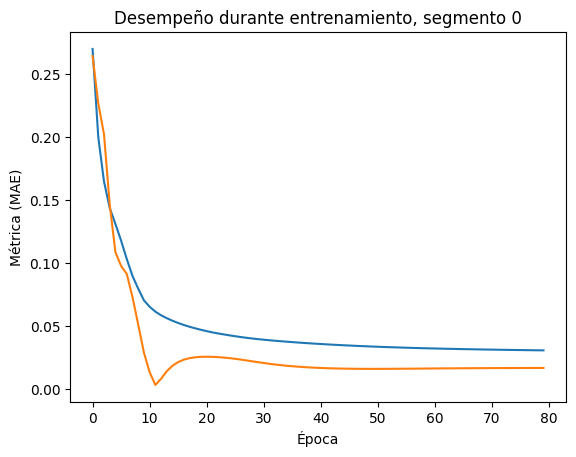

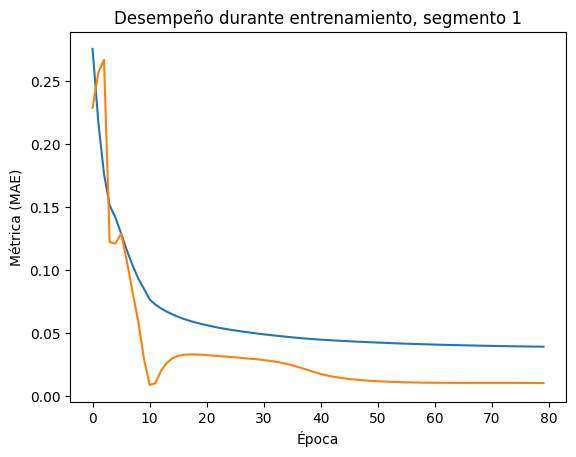

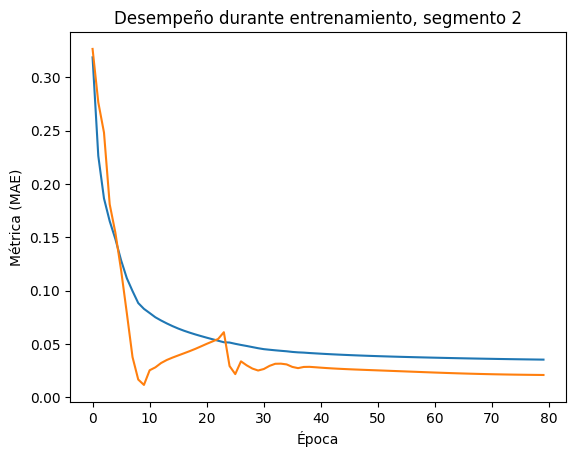

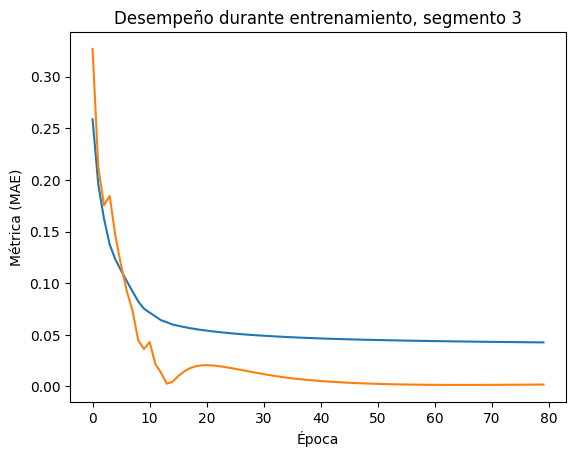

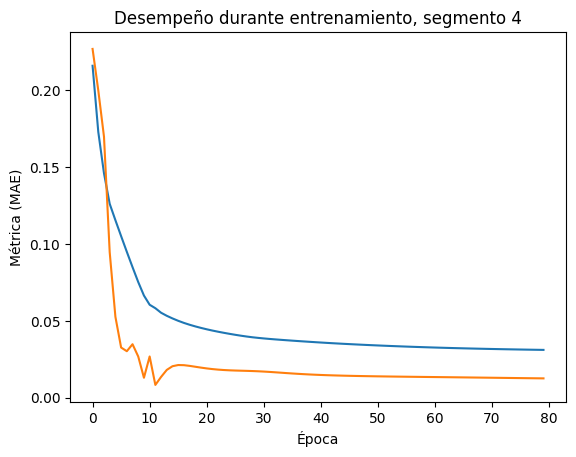

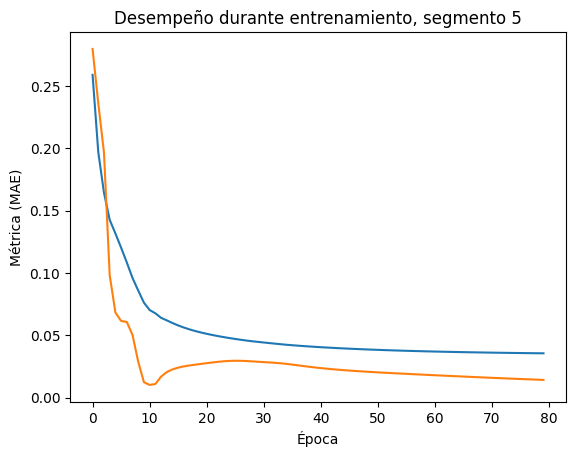

In [5]:
for i, seg in zip(range(len(results_base_generation)), segments_county0):
    plt.plot(results_base_generation.loc[i,'mae'], label='train_mae')
    plt.plot(results_base_generation.loc[i,'val_mae'], label='val_mae')
    plt.title(f'Desempeño durante entrenamiento, segmento {seg}')
    plt.xlabel('Época')
    plt.ylabel('Métrica (MAE)')
    plt.show()

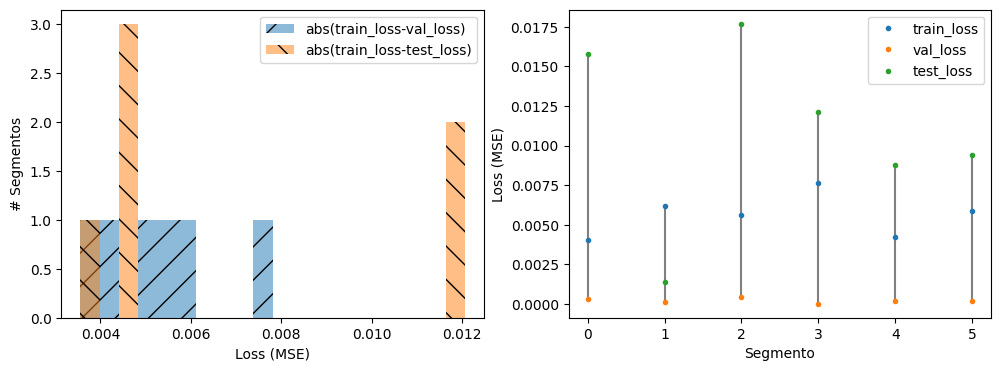

In [6]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
train_val_loss_abs = np.abs(results_base_generation['train_loss']-results_base_generation['validation_loss'])
train_test_loss_abs = np.abs(results_base_generation['train_loss']-results_base_generation['test_loss'])
full_range = (min(train_val_loss_abs.min(), train_test_loss_abs.min()), max(train_val_loss_abs.max(), train_test_loss_abs.max()))
plt.hist(train_val_loss_abs, alpha=0.5, hatch='/', label='abs(train_loss-val_loss)', range=full_range, bins=20)
plt.hist(train_test_loss_abs, alpha=0.5, hatch='\\', label='abs(train_loss-test_loss)', range=full_range, bins=20)
plt.xlabel('Loss (MSE)')
plt.ylabel('# Segmentos')
plt.legend()

plt.subplot(1,2,2)

for i in range(len(results_base_generation)):
    x_ini = i
    y_ini = min(results_base_generation.loc[i,['train_loss','validation_loss','test_loss']])
    y_end = max(results_base_generation.loc[i,['train_loss','validation_loss','test_loss']])
    plt.vlines(x=x_ini, ymin=y_ini, ymax=y_end, color='gray', linestyle='-')

plt.plot(results_base_generation['train_loss'], '.', label='train_loss')
plt.plot(results_base_generation['validation_loss'], '.', label='val_loss')
plt.plot(results_base_generation['test_loss'], '.', label='test_loss')
plt.ylabel("Loss (MSE)")
plt.xlabel('Segmento')
plt.legend()

plt.show()

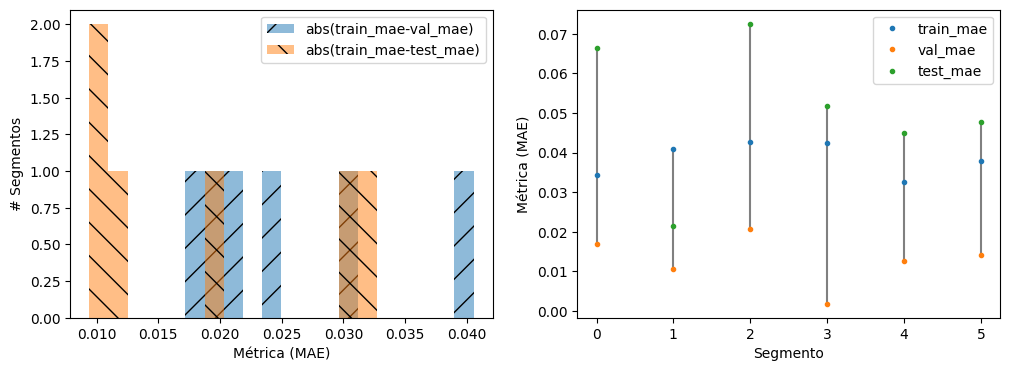

In [7]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
train_val_mae_abs = np.abs(results_base_generation['train_mae']-results_base_generation['validation_mae'])
train_test_mae_abs = np.abs(results_base_generation['train_mae']-results_base_generation['test_mae'])
full_range = (min(train_val_mae_abs.min(), train_test_mae_abs.min()), max(train_val_mae_abs.max(), train_test_mae_abs.max()))
plt.hist(train_val_mae_abs, alpha=0.5, hatch='/', label='abs(train_mae-val_mae)', range=full_range, bins=20)
plt.hist(train_test_mae_abs, alpha=0.5, hatch='\\', label='abs(train_mae-test_mae)', range=full_range, bins=20)
plt.xlabel('Métrica (MAE)')
plt.ylabel('# Segmentos')
plt.legend()

plt.subplot(1,2,2)

for i in range(len(results_base_generation)):
    x_ini = i
    y_ini = min(results_base_generation.loc[i,['train_mae','validation_mae','test_mae']])
    y_end = max(results_base_generation.loc[i,['train_mae','validation_mae','test_mae']])
    plt.vlines(x=x_ini, ymin=y_ini, ymax=y_end, color='gray', linestyle='-')

plt.plot(results_base_generation['train_mae'], '.', label='train_mae')
plt.plot(results_base_generation['validation_mae'], '.', label='val_mae')
plt.plot(results_base_generation['test_mae'], '.', label='test_mae')
plt.ylabel("Métrica (MAE)")
plt.xlabel('Segmento')
plt.legend()

plt.show()

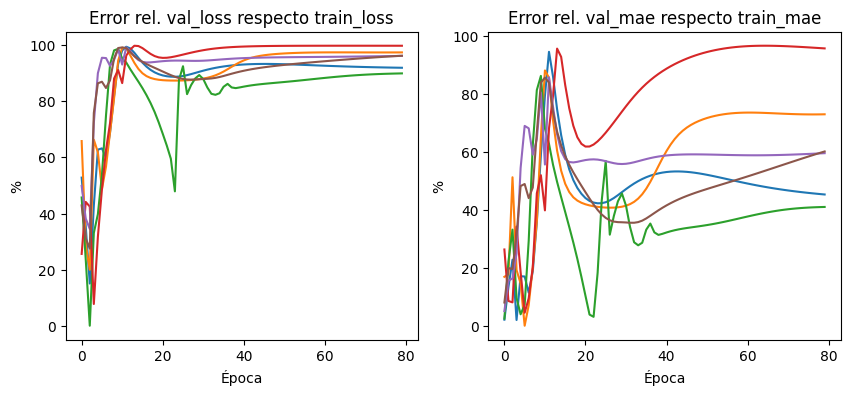

In [8]:

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)

relative_error_train_val_loss = results_base_generation[['loss', 'val_loss']].apply(
    lambda x: np.abs(np.array(x['val_loss'])-np.array(x['loss']))/np.array(x['loss'])*100,
    axis=1
)

for serie in relative_error_train_val_loss:
    plt.plot(serie)

plt.title('Error rel. val_loss respecto train_loss')
plt.xlabel('Época')
plt.ylabel('%')

plt.subplot(1,2,2)

relative_error_train_val_mae = results_base_generation[['mae', 'val_mae']].apply(
    lambda x: np.abs(np.array(x['val_mae'])-np.array(x['mae']))/np.array(x['mae'])*100,
    axis=1
)

for serie in relative_error_train_val_mae:
    plt.plot(serie)

plt.title('Error rel. val_mae respecto train_mae')
plt.xlabel('Época')
plt.ylabel('%')

plt.show()

c:\Users\david\OneDrive\Escritorio\ucc\enefit\venv_dl\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


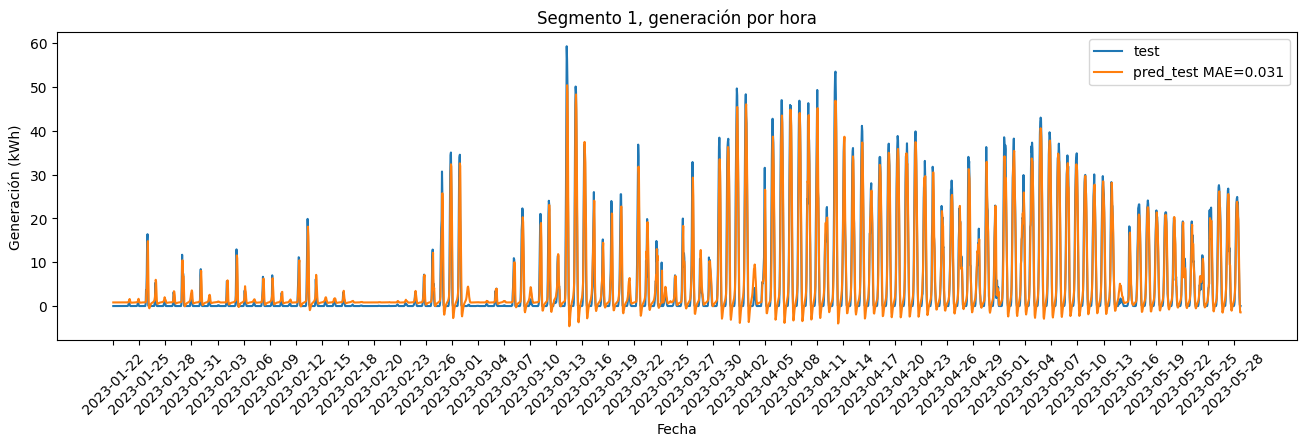

c:\Users\david\OneDrive\Escritorio\ucc\enefit\venv_dl\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


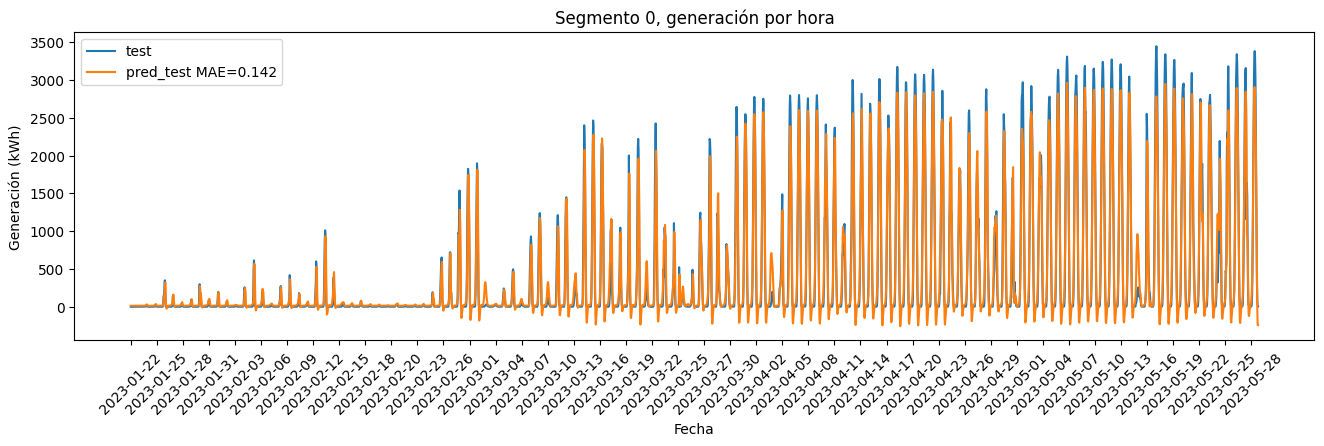

In [9]:
result_df = pd.read_csv('results_base_lstm_univ_unist_generation_county_0.csv')

some_segments = result_df.sort_values('test_mae')['segment'].values[[0,-1]]

INPUT_LENGTH = 24
OUTPUT_LENGTH = 1
EPOCHS = 50
BATCH_SIZE = 128
n_units = 64

for segment in some_segments:
    df_segment = df[(df['prediction_unit_id']==segment) & (df['is_consumption']==0)]
    train, validation, test = train_val_test_split(df_segment['target'], train_size=0.7)

    x_train, y_train = create_supervised_dataset(train.values, INPUT_LENGTH, OUTPUT_LENGTH)
    x_validation, y_validation = create_supervised_dataset(validation.values, INPUT_LENGTH, OUTPUT_LENGTH)
    x_test, y_test = create_supervised_dataset(test.values, INPUT_LENGTH, OUTPUT_LENGTH)

    data_input = {
        'x_train': x_train, 'y_train': y_train,
        'x_validation': x_validation, 'y_validation': y_validation,
        'x_test': x_test, 'y_test': y_test,
    }

    data_scaled, scaler = scale_dataset(data_input)

    x_train_s, y_train_s = data_scaled['x_train_s'], data_scaled['y_train_s']
    x_validation_s, y_validation_s = data_scaled['x_validation_s'], data_scaled['y_validation_s']
    x_test_s, y_test_s = data_scaled['x_test_s'], data_scaled['y_test_s']
    
    input_shape = x_train_s.shape[1:]

    tf.random.set_seed(123)
    tf.config.experimental.enable_op_determinism()

    model = Sequential()
    model.add(LSTM(n_units, input_shape=input_shape))
    model.add(Dense(OUTPUT_LENGTH, activation='linear'))

    optimizer = RMSprop(learning_rate=5e-5)

    model.compile(
        optimizer = optimizer,
        loss = 'mse',
        metrics = ['mae']
    )

    history = model.fit(
        x = x_train_s,
        y = y_train_s,
        batch_size = BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = (x_validation_s, y_validation_s),
        verbose=0
    )

    y_test_pred = predict(x_test_s, model, scaler)
    n = 70
    plt.figure(figsize=(16,4))
    plt.plot(y_test.flatten(), label='test')
    mae = result_df.loc[result_df[result_df['segment']==segment].index, 'test_mae']
    plt.plot(y_test_pred, label=f'pred_test MAE={mae.round(3).values[0]}')
    plt.legend()
    plt.ylabel('Generación (kWh)')
    plt.xlabel('Fecha')
    plt.xticks(range(0, len(test), n), list(test.index.date)[::n], rotation=45)
    plt.title(f"Segmento {segment}, generación por hora")
    plt.show() 

c:\Users\david\OneDrive\Escritorio\ucc\enefit\venv_dl\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


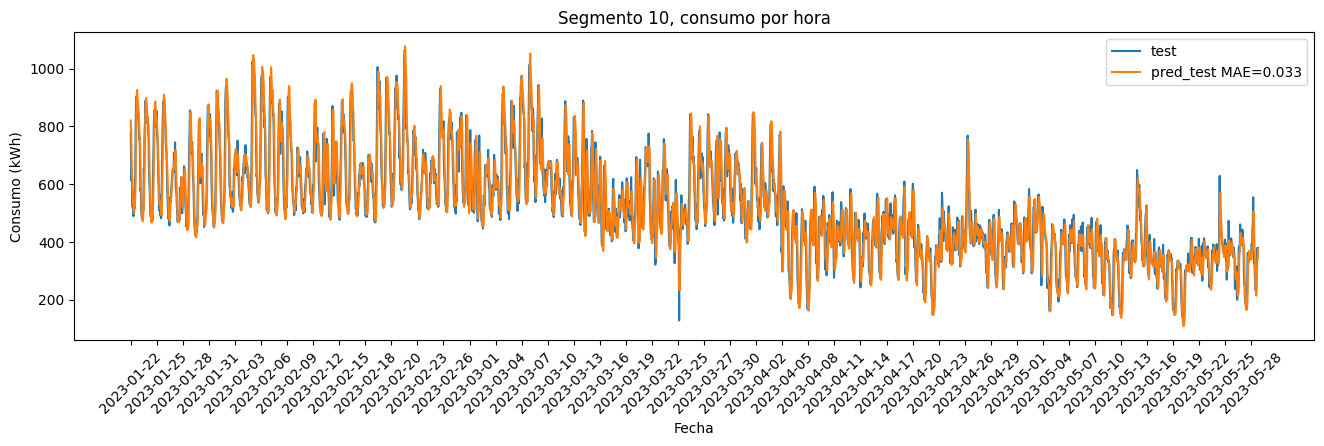

c:\Users\david\OneDrive\Escritorio\ucc\enefit\venv_dl\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


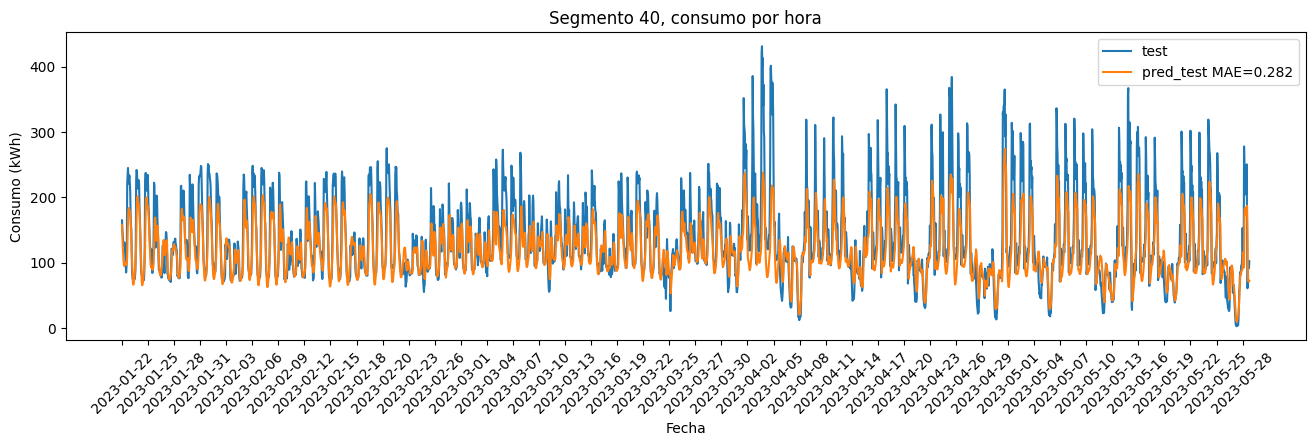

In [11]:
result_df = pd.read_csv('results_base_lstm_univ_unist_consumption.csv')

some_segments = result_df.sort_values('test_mae')['segment'].values[[0,-1]]

INPUT_LENGTH = 24
OUTPUT_LENGTH = 1
EPOCHS = 50
BATCH_SIZE = 128
n_units = 64

for segment in some_segments:
    df_segment = df[(df['prediction_unit_id']==segment) & (df['is_consumption']==1)]
    train, validation, test = train_val_test_split(df_segment['target'], train_size=0.7)

    x_train, y_train = create_supervised_dataset(train.values, INPUT_LENGTH, OUTPUT_LENGTH)
    x_validation, y_validation = create_supervised_dataset(validation.values, INPUT_LENGTH, OUTPUT_LENGTH)
    x_test, y_test = create_supervised_dataset(test.values, INPUT_LENGTH, OUTPUT_LENGTH)

    data_input = {
        'x_train': x_train, 'y_train': y_train,
        'x_validation': x_validation, 'y_validation': y_validation,
        'x_test': x_test, 'y_test': y_test,
    }

    data_scaled, scaler = scale_dataset(data_input)

    x_train_s, y_train_s = data_scaled['x_train_s'], data_scaled['y_train_s']
    x_validation_s, y_validation_s = data_scaled['x_validation_s'], data_scaled['y_validation_s']
    x_test_s, y_test_s = data_scaled['x_test_s'], data_scaled['y_test_s']
    
    input_shape = x_train_s.shape[1:]

    tf.random.set_seed(123)
    tf.config.experimental.enable_op_determinism()

    model = Sequential()
    model.add(LSTM(n_units, input_shape=input_shape))
    model.add(Dense(OUTPUT_LENGTH, activation='linear'))

    optimizer = RMSprop(learning_rate=5e-5)

    model.compile(
        optimizer = optimizer,
        loss = 'mse',
        metrics = ['mae']
    )

    history = model.fit(
        x = x_train_s,
        y = y_train_s,
        batch_size = BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = (x_validation_s, y_validation_s),
        verbose=0
    )

    y_test_pred = predict(x_test_s, model, scaler)
    n = 70
    plt.figure(figsize=(16,4))
    plt.plot(y_test.flatten(), label='test')
    mae = result_df.loc[result_df[result_df['segment']==segment].index, 'test_mae']
    plt.plot(y_test_pred, label=f'pred_test MAE={mae.round(3).values[0]}')
    plt.legend()
    plt.ylabel('Consumo (kWh)')
    plt.xlabel('Fecha')
    plt.xticks(range(0, len(test), n), list(test.index.date)[::n], rotation=45)
    plt.title(f"Segmento {segment}, consumo por hora")
    plt.show() 